In [ ]:
# %% Importações necessárias

import pandas as pd              # Manipulação de DataFrames
import matplotlib.pyplot as plt  # Geração de gráficos
import seaborn as sns            # Geração de gráficos
import numpy as np               # Operações matemáticas
from sklearn.cluster import KMeans, DBSCAN  # Algoritmos de clusterização
from sklearn.metrics import silhouette_score # Avaliação de clusters
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram # Clusterização hierárquica
import umap  # Redução de dimensionalidade para visualização

c:\Users\maype\Desktop\projetos\Trabalho Prático AM2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %% Carregando os dados

# Substitua pelo caminho correto para seu arquivo
fatores_df = pd.read_csv(r'C:\Users\maype\Desktop\projetos\Trabalho Prático AM2\data\base_fatores.csv', index_col=0)
fatores_umap = pd.read_csv(r'C:\Users\maype\Desktop\projetos\Trabalho Prático AM2\data\fatores_umap.csv', index_col=0)

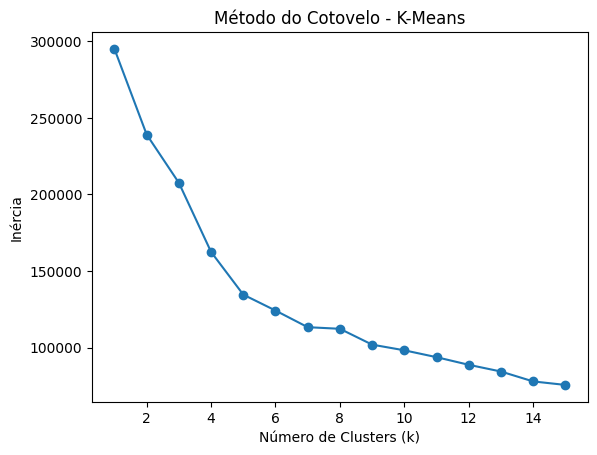

In [ ]:
# %% Método do Cotovelo para K-Means

def metodo_cotovelo(data, max_clusters=15):
    """
    Determina o número ideal de clusters para K-Means usando o método do cotovelo.

    Args:
        data: DataFrame com os dados para clusterização.
        max_clusters: Número máximo de clusters a serem testados.

    Returns:
        None. Mostra o gráfico do método do cotovelo.
    """
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0) # random_state para reprodutibilidade
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Método do Cotovelo - K-Means')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inércia')
    plt.show()

# Aplicando o método do cotovelo aos dados de fatores
metodo_cotovelo(fatores_df.drop('diagnostico_hipertensao', axis=1))

In [ ]:
# %% Clusterização com K-Means

# Escolha do k com base no gráfico do método do cotovelo 
k = 7  # Substitua pelo k escolhido
kmeans = KMeans(n_clusters=k, random_state=0)
clusters_kmeans = kmeans.fit_predict(fatores_df.drop('diagnostico_hipertensao', axis=1))
fatores_df['cluster_kmeans'] = clusters_kmeans

In [ ]:
# %% Clusterização com DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean') # Ajuste eps e min_samples conforme necessário
clusters_dbscan = dbscan.fit_predict(fatores_df.drop('diagnostico_hipertensao', axis=1))
fatores_df['cluster_dbscan'] = clusters_dbscan

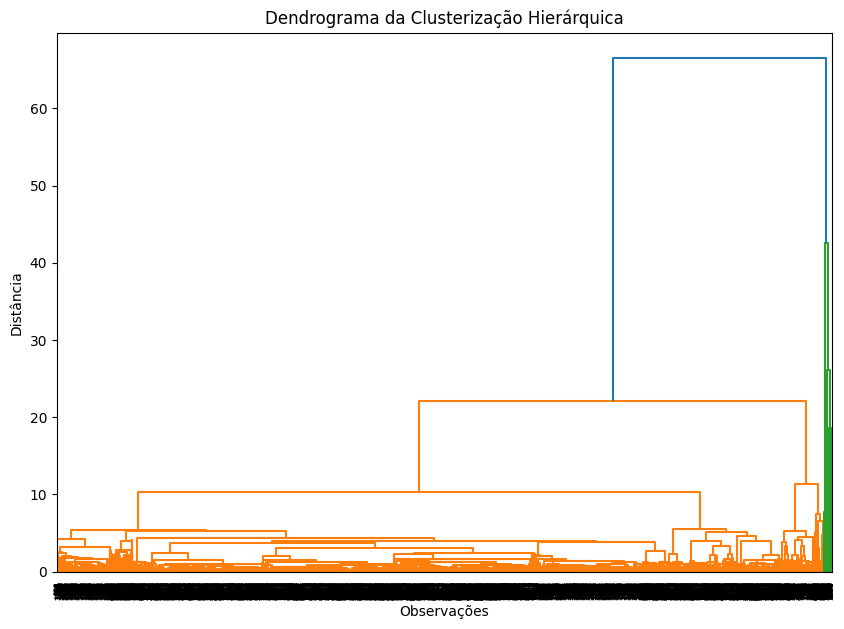

In [ ]:
# %% Clusterização Hierárquica Aglomerativa

frac = 0.10 # 10% da amostra
fatores_df_amostra = fatores_df.groupby('diagnostico_hipertensao').sample(frac=frac, random_state=42) # agrupando pelos valores de diagnostico, random_state para reprodutibilidade

# Agora aplique a clusterização hierárquica apenas aos dados amostrados:
linkage_matrix = linkage(fatores_df_amostra.drop('diagnostico_hipertensao', axis=1), method='centroid') #Utilizando o metodo centroid por ser mais rápido que o ward

clusters_hierarquico = fcluster(linkage_matrix, t=k, criterion='maxclust') # Usando o mesmo k do K-Means para comparação

# Cria um novo DataFrame com os dados amostrados e os clusters
fatores_amostra_clusters = fatores_df_amostra.copy()
fatores_amostra_clusters['cluster_hierarquico'] = clusters_hierarquico

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma da Clusterização Hierárquica')
plt.xlabel('Observações')
plt.ylabel('Distância')
plt.show()

In [ ]:
# %% Avaliação com Silhouette Score

silhouette_kmeans = silhouette_score(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_kmeans, metric='euclidean')
silhouette_dbscan = silhouette_score(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_dbscan, metric='euclidean')
silhouette_hierarquico = silhouette_score(fatores_amostra_clusters.drop('diagnostico_hipertensao', axis=1), clusters_hierarquico, metric='euclidean')

print(f'Silhouette Score K-Means: {silhouette_kmeans:.3f}')
print(f'Silhouette Score DBSCAN: {silhouette_dbscan:.3f}')
print(f'Silhouette Score Hierárquico: {silhouette_hierarquico:.3f}')

Silhouette Score K-Means: 0.222
Silhouette Score DBSCAN: 0.577
Silhouette Score Hierárquico: 0.637


c:\Users\maype\Desktop\projetos\Trabalho Prático AM2\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


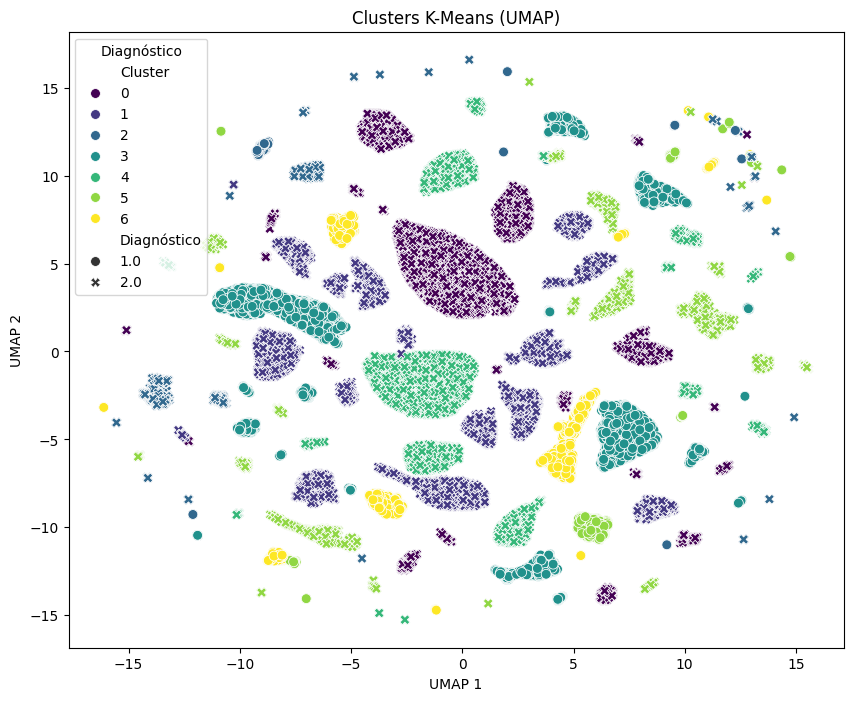

c:\Users\maype\Desktop\projetos\Trabalho Prático AM2\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


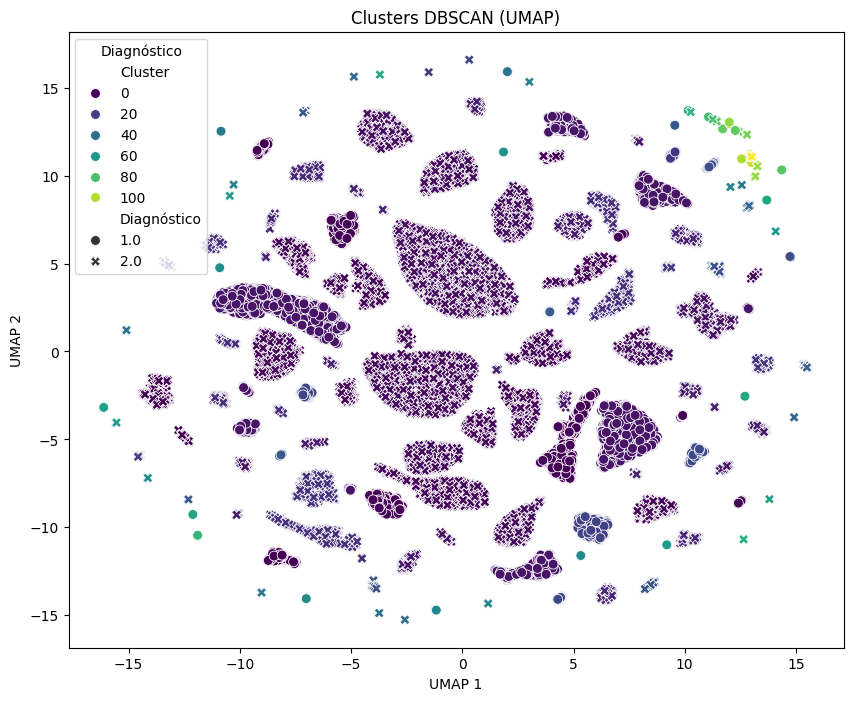

c:\Users\maype\Desktop\projetos\Trabalho Prático AM2\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


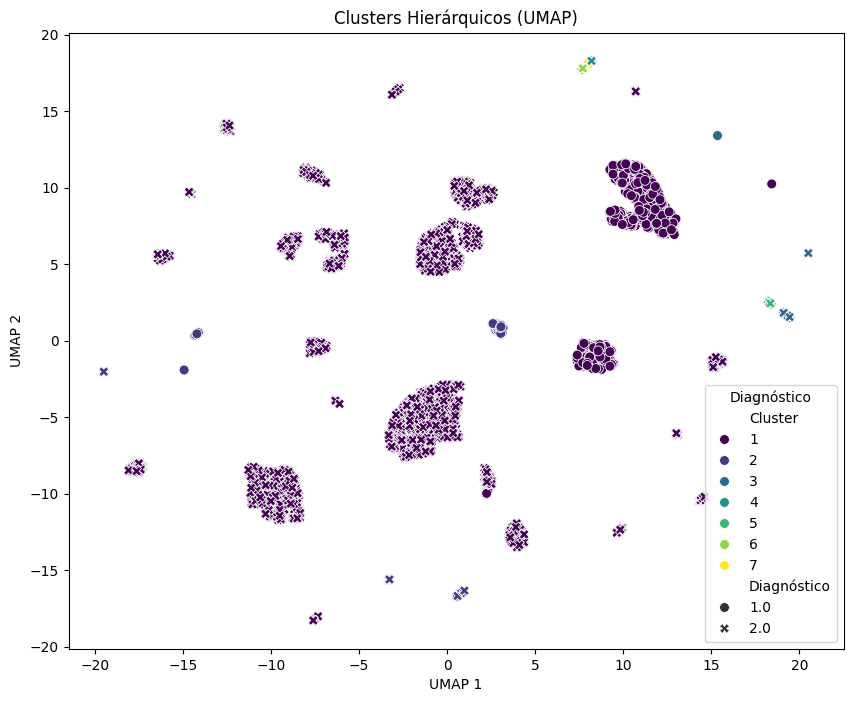

In [ ]:
#%%

def plot_clusters_umap_seaborn(data, labels, diagnostico, titulo):
    """
    Projeta os dados em 2D usando UMAP e plota os clusters com a variável target usando Seaborn.
    """
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(data)

    # Criando um DataFrame para usar com o Seaborn
    df_plot = pd.DataFrame({'UMAP1': embedding[:, 0], 'UMAP2': embedding[:, 1], 'Cluster': labels, 'Diagnóstico': diagnostico})

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='Cluster', style='Diagnóstico', palette='viridis', s=50)  # Usa o Seaborn para plotar

    plt.title(titulo)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Diagnóstico')  #Legenda melhorada
    plt.show()


# Exemplo de uso:
plot_clusters_umap_seaborn(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_kmeans, fatores_df['diagnostico_hipertensao'], 'Clusters K-Means (UMAP)')
plot_clusters_umap_seaborn(fatores_df.drop('diagnostico_hipertensao', axis=1), clusters_dbscan, fatores_df['diagnostico_hipertensao'], 'Clusters DBSCAN (UMAP)')
plot_clusters_umap_seaborn(fatores_amostra_clusters.drop('diagnostico_hipertensao', axis=1), clusters_hierarquico, fatores_amostra_clusters['diagnostico_hipertensao'], 'Clusters Hierárquicos (UMAP)')

In [ ]:
# %%

def calcular_pureza(df, cluster_column, target_column):
    """
    Calcula a pureza dos clusters.  A pureza mede a porcentagem de pontos em cada cluster que pertencem à classe majoritária naquele cluster.

    Args:
        df: DataFrame com as colunas de clusters e target.
        cluster_column: Nome da coluna com os rótulos dos clusters (string).
        target_column: Nome da coluna com a variável target (string).

    Returns:
        A pureza dos clusters (float entre 0 e 1).
    """
    clusters = df[cluster_column].unique()  # Obtém os rótulos únicos dos clusters
    pureza_total = 0
    for cluster in clusters:  # Itera sobre cada cluster
        cluster_data = df[df[cluster_column] == cluster]  # Seleciona os dados de um cluster
        contagens = cluster_data[target_column].value_counts()  # Conta as ocorrências de cada classe no cluster
        pureza_total += contagens.max()  # Soma a contagem da classe majoritária
    return pureza_total / len(df)  # Calcula a pureza média


pureza_kmeans = calcular_pureza(fatores_df, 'cluster_kmeans', 'diagnostico_hipertensao')
pureza_dbscan = calcular_pureza(fatores_df, 'cluster_dbscan', 'diagnostico_hipertensao')
pureza_hierarquico = calcular_pureza(fatores_amostra_clusters, 'cluster_hierarquico', 'diagnostico_hipertensao')

print(f"Pureza K-Means: {pureza_kmeans:.4f}")
print(f"Pureza DBSCAN: {pureza_dbscan:.4f}")
print(f"Pureza Hierárquica: {pureza_hierarquico:.4f}")

Pureza K-Means: 0.9715
Pureza DBSCAN: 0.9823
Pureza Hierárquica: 0.7662
